# Importing Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

# Creating functions

In [4]:
def read_image(image):
    return cv2.imread(image)

def show_image(image):
    cv2.namedWindow('image',cv2.WINDOW_KEEPRATIO)
    cv2.imshow('image',image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
def detect_markers(image):
    '''Returns an image with highlighted corners and marker corner co-ordinates'''
   # image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    #Loading the dictionary that was used to generate the markers. Marker used in this task contains a 6X6 matrix. 
    dictionary = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_1000)
 
    # Initializing the detector parameters using default values
    parameters =  cv2.aruco.DetectorParameters_create()
 
    # Detecting the marker in the image by obtaining its corners
    marker_corners, markerid, rejectedCandidates = cv2.aruco.detectMarkers(image, dictionary, parameters=parameters)
    
    return marker_corners[0][0].astype(int)

def grab_corners(image):
    points = np.array([
                      [0,0],
                      [(image.shape[1])-1,0],
                      [(image.shape[1])-1,(image.shape[0])-1],
                      [0,(image.shape[0])-1]
                      ])
    return points

def remove_black_pixels(image):
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i,j].any() == 0 :
                image[i,j] = [1,1,1]
                
    return image

def get_polygon_width_height(arucode_marker_corners):
    polygon_width = int((abs(arucode_marker_corners[0,0]-arucode_marker_corners[1,0])+abs(arucode_marker_corners[2,0]-arucode_marker_corners[3,0]))/2)
    polygon_height = int((abs(arucode_marker_corners[0,1]-arucode_marker_corners[3,1])+abs(arucode_marker_corners[1,1]-arucode_marker_corners[2,1]))/2)
    return polygon_width, polygon_height

def create_polygon_in_frame(polygon_width, polygon_height,frame_center):
    polygon_in_frame = np.array([[frame_center[0]-0.5*polygon_width,frame_center[1]-0.5*polygon_height],
                                [frame_center[0]+0.5*polygon_width,frame_center[1]-0.5*polygon_height],
                                [frame_center[0]+0.5*polygon_width,frame_center[1]+0.5*polygon_height],
                                [frame_center[0]-0.5*polygon_width,frame_center[1]+0.5*polygon_height]])
    return polygon_in_frame

# Creating master function

In [ ]:
def augment_image(frame, image_with_marker):
    frame = remove_black_pixels(frame)
    frame_corners = grab_corners(frame)
    frame_center = np.median(frame_corners,axis = 0)
    marker_corners = detect_markers(image_with_marker)
    #polygon_width, polygon_height = get_polygon_width_height(marker_corners)
    polygon_in_frame = create_polygon_in_frame(polygon_width=200, polygon_height=200, frame_center=frame_center)
    
    
    transformation_matrix = cv2.getPerspectiveTransform(polygon_in_frame.astype(np.float32),marker_corners.astype(np.float32))
    
    warped_image = cv2.warpPerspective(frame,transformation_matrix,dsize = (image_with_marker.shape[1],image_with_marker.shape[0]))
    
    mask = np.zeros_like(image_with_marker)
    for i in range(warped_image.shape[0]):
        for j in range(warped_image.shape[1]):
            if warped_image[i,j].any() == 0:
                mask[i,j] = 255
    image_with_marker_black = cv2.bitwise_and(mask,image_with_marker)
    augmented_frame = cv2.bitwise_or(warped_image,image_with_marker_black)
    return augmented_frame
        
    

# Testing 

In [9]:
pisa = read_image('Pisa.jpg')    
classroom = read_image(f'Detected Markers\Images\Angle3_H.png')

augmented_frame = augment_image(pisa,classroom)

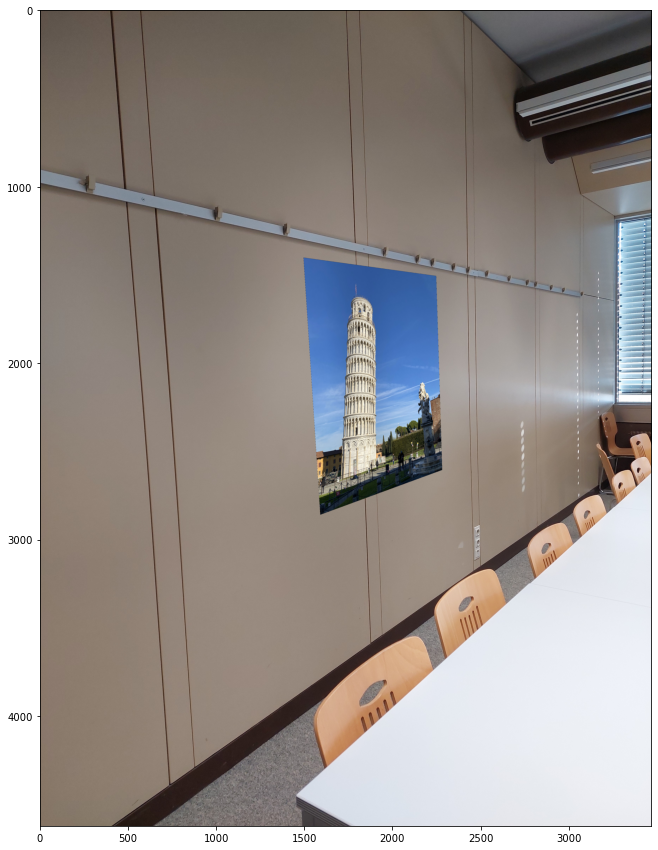

In [19]:
preview = cv2.cvtColor(augmented_frame,cv2.COLOR_BGR2RGB)
plt.figure(figsize = (15,15))
plt.imshow(preview)